In [1]:
%%time
import sys, os
year = '2023'
path_gen = '/home/eliasmfs/Erasmus MC/Projects/Cerebellar_Open_Closed_Loops'
path_data = f'/mnt/User_Data/UserData/eliasmfs/Cerebellar_Open_Closed_Loops/SlowData/'
path_code = f'{path_gen}'
path_functions = f'{path_code}/Functions'
sys.path.append(path_data)
sys.path.append(path_functions)

from Run import *
from tqdm import tqdm
from scipy.signal import butter, lfilter, sosfiltfilt, find_peaks
import matplotlib.style as style 
style.use('seaborn-colorblind')


record = {}
record['Noise'] = True
record['PC'] = True
record['DCN'] = True
record['IO'] = True 
record['conn_N_PC'] = True
record['Input_presyn'] = True

save = 1
show = 0

noise_gain_range =  [1]

exp_run = 60000*ms
N_Cells_PC = 200
N_Cells_DCN = 40
N_Cells_IO = 40
N_Cells_PF = 5
plasticity_range = ['no_Plasticity']#,'Plasticity','after_Plasticity']
coupling_range = ['_Coupled']
zebrin_range = ['positive', 'negative']

                
seed_number_range = ['closed_open_loops_diff_tau']
sims = ['pulse_open']
seed_number = seed_number_range[0]

zebrin = zebrin_range[0]
noise_gain = 1

range_plasticity = ['Plasticity']
range_after_plasticity = ['after_Plasticity']

plas_range = 1
if plas_range > 1:
    for plas_num in range(2,plas_range+1):
        plasticity_range.append(f'Plasticity{plas_num}')
        range_plasticity.append(f'Plasticity{plas_num}')
        plasticity_range.append(f'after_Plasticity{plas_num}')
        range_after_plasticity.append(f'after_Plasticity{plas_num}')
        
f0_range = [sims[0]]

parameters_value = { "range_plasticity": range_plasticity, "range_after_plasticity": range_after_plasticity,
                    "PC_I_intrinsic": 0.15, "thresh_M": 60*Hz, "delta_weight_BCM": 0, "delta_weight_CS": -0.1,#-0.02

                    "unfiltered": True, "filtered": True, "f0_range": f0_range, "filter_order": 6, 
                    "positive":{
                        "Uncoupled":{'w_IO_DCN': -2.0, 'PC_DCN': 5.0, 'leak': 0.001, 'gCal': 1.2, 'b_OU': -0.7, 
                                     'sigma_OU': 0.7},
                        'Coupled': {'w_IO_DCN': -2.0, 'PC_DCN': 5.0, 'leak': 0.001, 'gCal': 1.4, 'b_OU': -0.3,
                                    'sigma_OU': 0.7}},
                    'negative':{
                        'Uncoupled': {'w_IO_DCN': -1.8, 'PC_DCN': 4.0, 'leak': 0.001, 'gCal': 1.4, 'b_OU': -0.3,
                                      'sigma_OU': 0.3},
                        'Coupled': {'w_IO_DCN': -1.8, 'PC_DCN': 4.0, 'leak': 0.001, 'gCal': 1.4, 'b_OU': -0.6, 
                                    'sigma_OU': 0.7}}}


Params, Noise_frozen, Values, Synaps, net_name = frozen_tun(seed_number_range,N_Cells_PC,N_Cells_DCN,N_Cells_IO,path_data,exp_run)
IO_num_con = Synaps['Seed_'+str(seed_number)].IO_PC_Synapse_Sources

dt = Params['Seed_'+str(seed_number)].dt
dt_rec = float(Params['Seed_'+str(seed_number)].dt_rec)
time_x = [x * dt for x in range(0,int(exp_run/dt))]
time_x_rec = [x * dt for x in range(0,int(exp_run/dt_rec))]


coupling = '_Coupled'
plasticity = 'no_Plasticity'
f0 = 0

zebrin_col = dict(positive='b',negative='r')
linstyle = dict(no_Plasticity='-',after_Plasticity='--')

WARNING    <timed exec>:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
 [py.warnings]



CPU times: user 16 s, sys: 8.66 s, total: 24.6 s
Wall time: 23.8 s


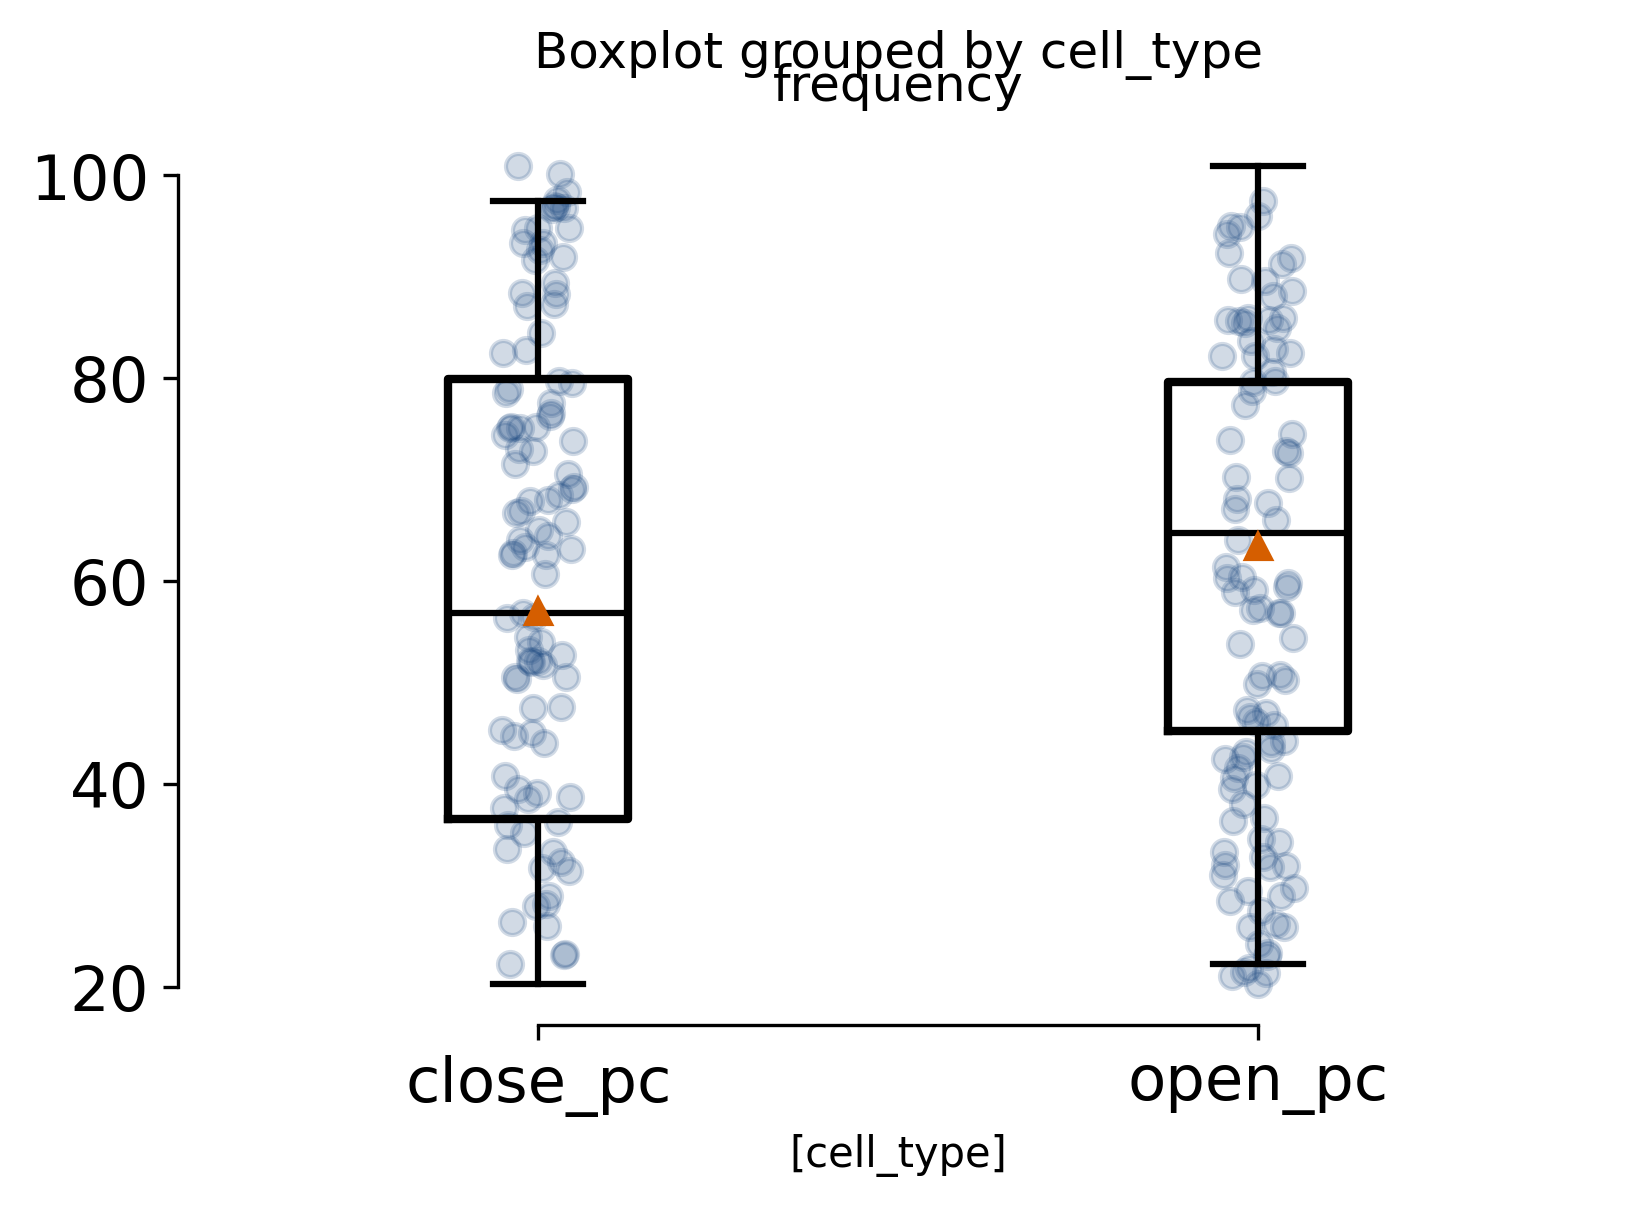

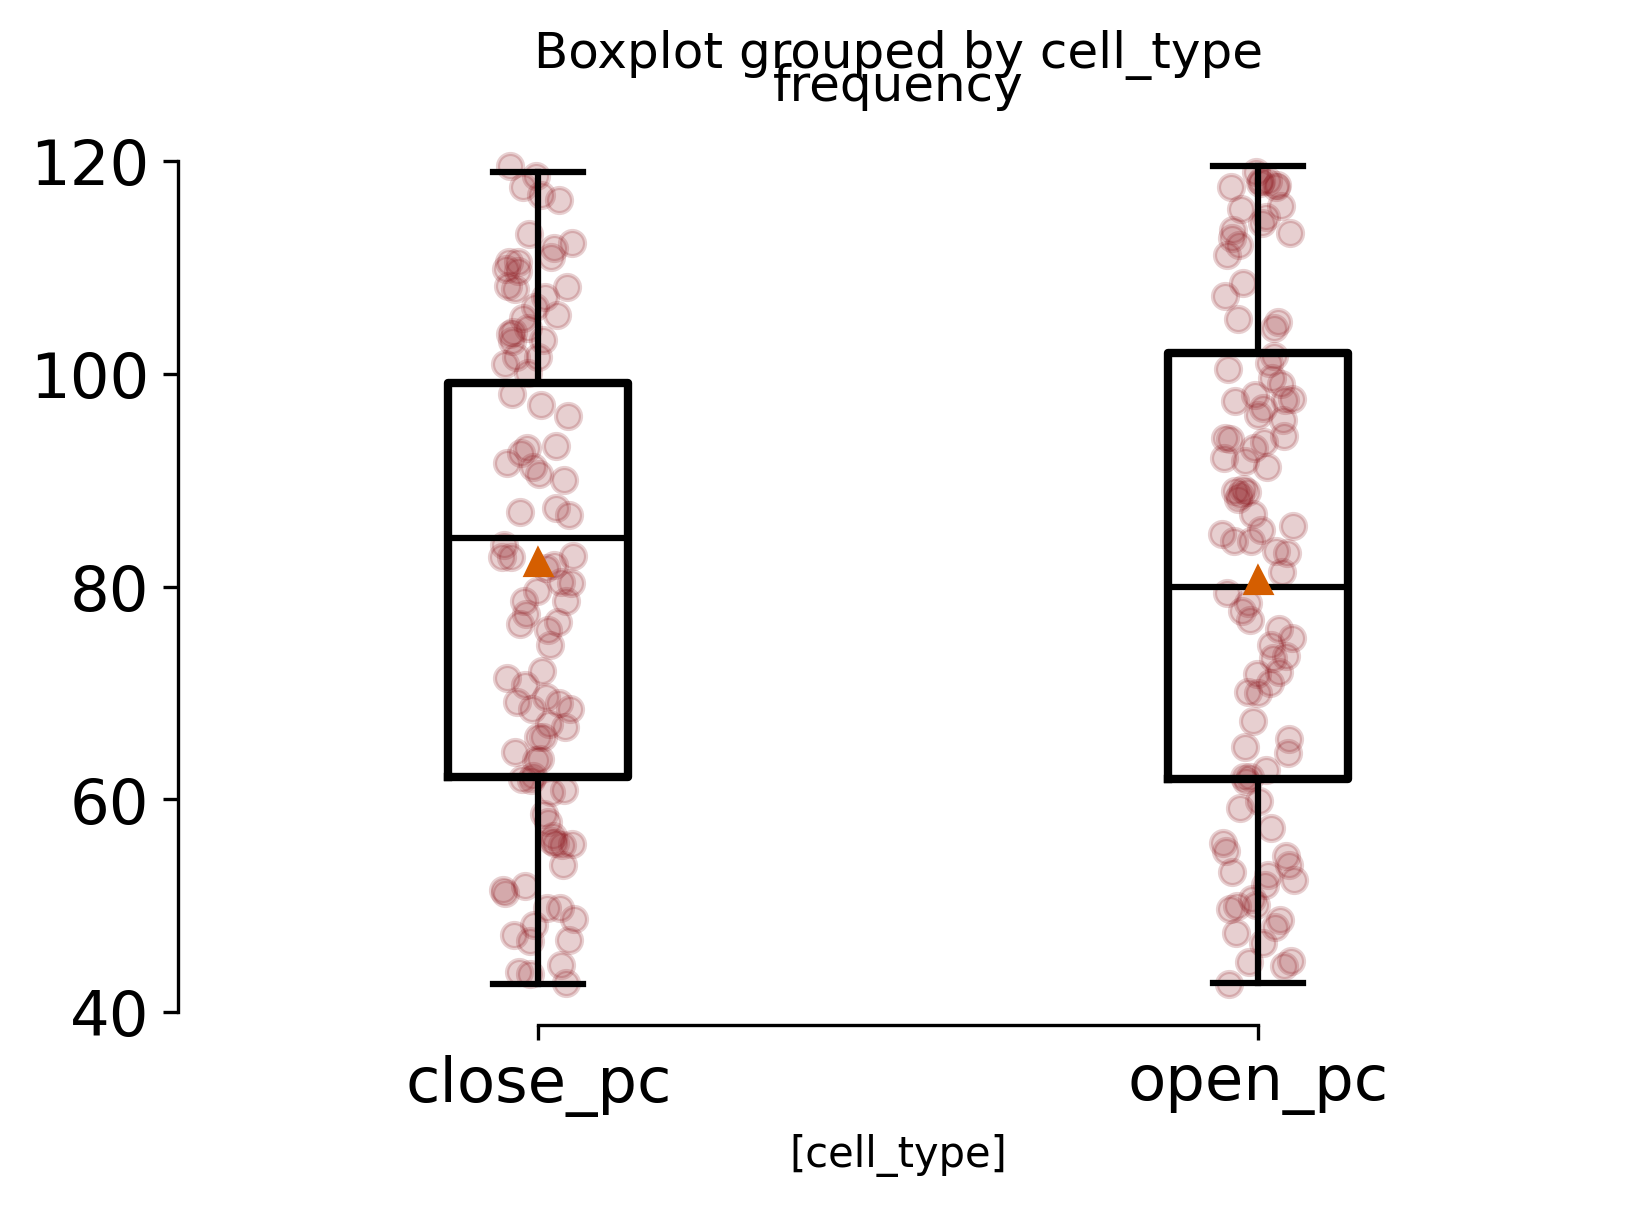

CPU times: user 409 ms, sys: 248 ms, total: 657 ms
Wall time: 644 ms


In [17]:
%%time
t_start = 1 * second
t_stop = 59 * second
bin_size = 1 * second
coupling = '_Coupled'

f0 = 'pulse_open'

names = {'no_Plasticity': 'NP', 'Plasticity': 'P1', 'after_Plasticity': 'AP1'}
colors = dict(positive='#1c4981',negative='#8a1218')        
cell_pop_sizes = dict(all_pc = range(200),close_pc = range(100),open_pc = range(100,200),IO=range(40))
        
data = []
cell_name = 'PC'
for coupling in (['_Coupled']):
    for cell_type in ['close_pc','open_pc']:
        for zebrin in zebrin_range:
            for order,plasticity in enumerate(['no_Plasticity']):
                spikes_output = output_load_run(f'{cell_name}_Spikes',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
                for cell_num in cell_pop_sizes[cell_type]:
                    spikes = spikes_output[f'{cell_num}']
                    bin_edges = np.arange(t_start, t_stop+bin_size, bin_size)
                    spike_counts, _ = np.histogram(spikes, bins=bin_edges)
                    mean_count = spike_counts / bin_size
                    row = dict(frequency = mean(mean_count/Hz))
                    row['cell'] = cell_name
                    row['cell_type'] = cell_type
                    row['plasticity'] = names[f'{plasticity}']
                    row['zebrin'] = zebrin
                    row['coupling'] = coupling
                    row['order'] = f'{order}'+names[f'{plasticity}']
                    data.append(row)
df_ff = pd.DataFrame(data)

plasticity = 'no_Plasticity'

var = 'frequency'
x = {}
y = {}
for zebrin in zebrin_range:
    x[zebrin] = {}
    y[zebrin] = {}
    for cell_name in ['PC']:
        df_data = df_ff[(df_ff["zebrin"]==zebrin) & (df_ff["cell"]==cell_name) & (df_ff["plasticity"]==names[f'{plasticity}'])]
        Q1, Q3 = percentile(df_data['frequency'],[5,95])
        IQR = Q3 - Q1    #IQR is interquartile range. 
        lower_boundary = Q1 - 1.5 * IQR
        upper_boundary = Q3 + 1.5 * IQR
        df_data2 = df_data[(df_data['frequency'] < upper_boundary) & (df_data['frequency'] > lower_boundary)]
        fig = plt.figure(dpi=300)
        title(f'{cell_name}')

        flierproperties = dict(markerfacecolor = 'white', markeredgecolor = 'white')
        bp = df_data2.boxplot(column=var, by=['cell_type'], showmeans=True, grid=False, figsize=(4,3), widths=0.25,fontsize=15,
                             color=dict(boxes='k', whiskers='k', medians='k', caps='k'),
                             boxprops=dict(linestyle='-', linewidth=2),
                             flierprops=dict(linestyle='-', linewidth=1.5),
                             medianprops=dict(linestyle='-', linewidth=1.5, color = 'k'),
                             whiskerprops=dict(linestyle='-', linewidth=1.5),
                             capprops=dict(linestyle='-', linewidth=1.5),ax = plt.gca(),positions=[2,1])  
        colors = dict(positive='#1c4981',negative='#8a1218')   
        x[zebrin][cell_name] = {}
        y[zebrin][cell_name] = {}
        for i,coupling in enumerate(['close_pc','open_pc']):
            y[zebrin][cell_name][f'{coupling}'] = df_data2.frequency[(df_data2.cell_type==coupling) & (df_data2.plasticity==names[f'{plasticity}'])].dropna()
#             x[zebrin][cell_name][f'{coupling}'] = [1+i]*len(y[zebrin][cell_name][f'{coupling}'])
            x[zebrin][cell_name][f'{coupling}'] = rand_params(1+i, 1, len(y[zebrin][cell_name][f'{coupling}']), 0.001)#np.random.normal(1+j+(len(plasticity_range[0:1]))*i, 0.12, size=len(y))    # Add some random "jitter" to the x-axis
            scatter(x[zebrin][cell_name][f'{coupling}'], y[zebrin][cell_name][f'{coupling}'], color=f'{colors[zebrin]}', alpha=0.2)
#         toPlot = zip(x[zebrin][cell_name]['close_pc'], y[zebrin][cell_name]['close_pc'], x[zebrin][cell_name]['open_pc'], y[zebrin][cell_name]['open_pc'])
#         for tuple in toPlot:
#             plot([tuple[0], tuple[2]], [tuple[1], tuple[3]], color=f'{colors[zebrin]}',alpha=0.2)
        xticks([1,2],['close_pc','open_pc'])
        sns.despine(trim=True)
        plt.show()
    
    

(29000.0, 31000.0)

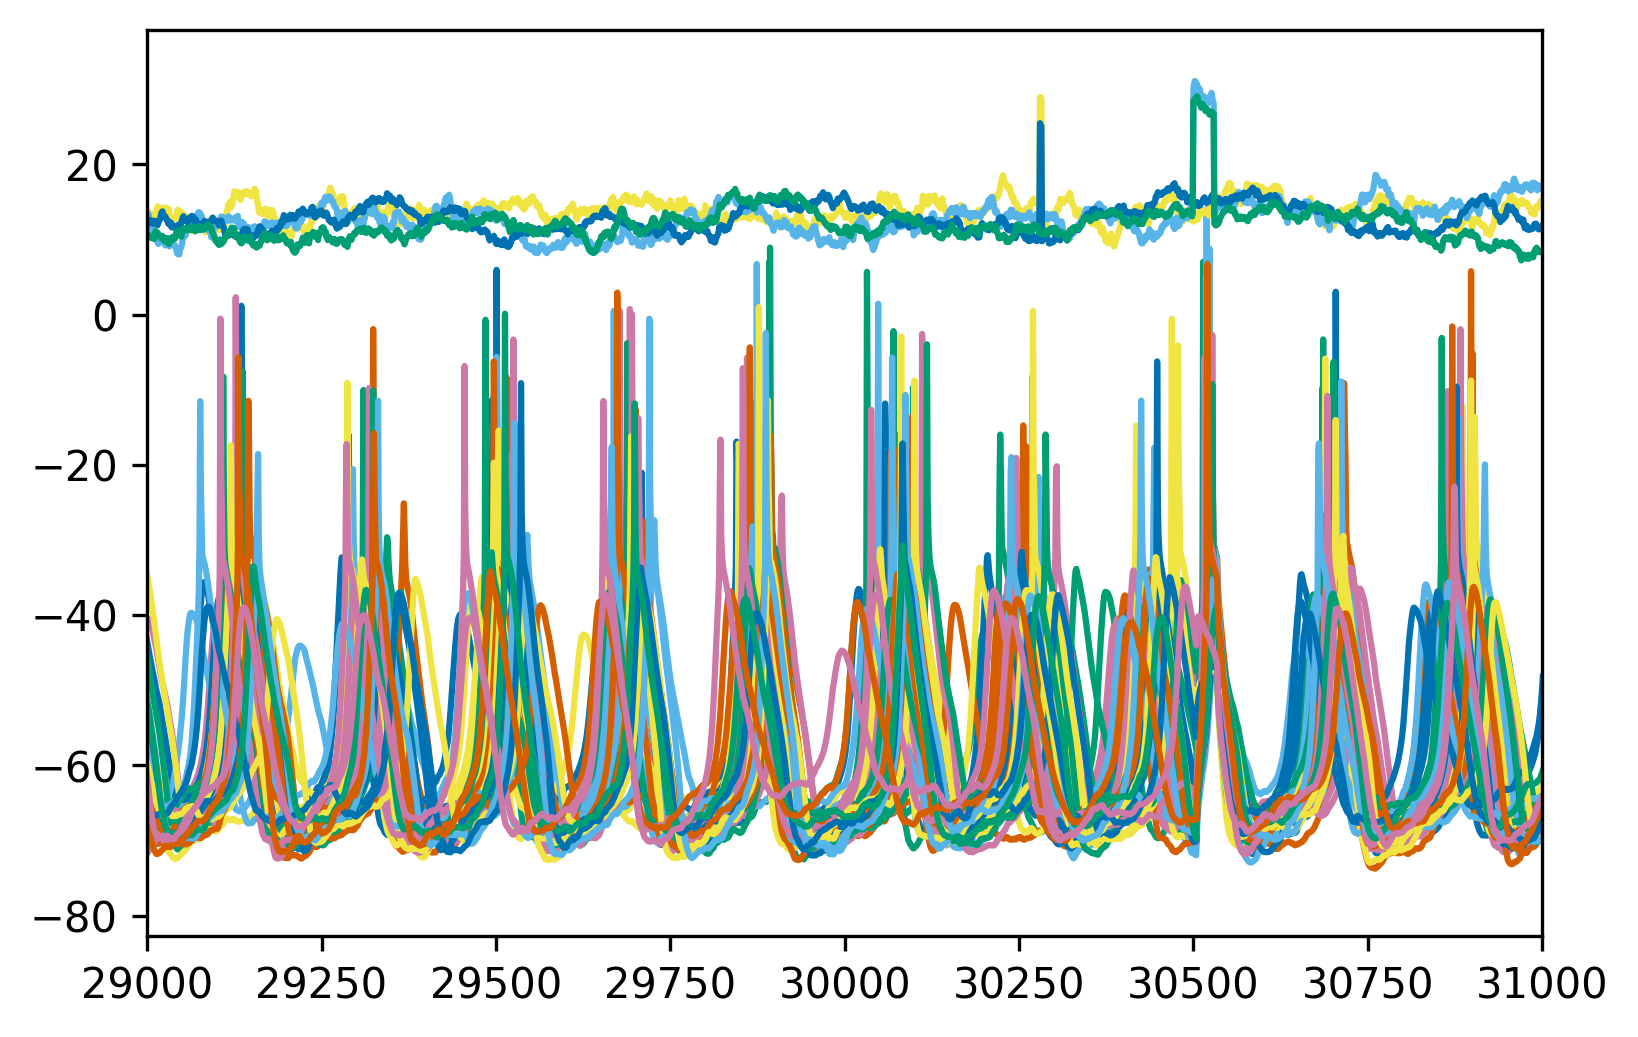

In [3]:
coupling = '_Coupled'
fig = plt.figure(dpi=300)
IO_v = output_load_run(f'IO',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)['Vs']
for ii in range(len(IO_v)):
    plot(IO_v[ii]/mV)
IO_v = output_load_run(f'Noise',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)['I']
for ii in [3,4,8,9]:
    plot(IO_v[ii]*10/nA)
xlim(29000,31000)

In [13]:

data = []
cell_name = 'IO'
for coupling in (['_Coupled']):
    for zebrin in ['positive','negative']:
        for order,plasticity in enumerate(['no_Plasticity']):
            spikes_output = output_load_run(f'{cell_name}_Spikes',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
            for cell_num in cell_pop_sizes[cell_name]:
                spikes = spikes_output[f'{cell_num}']
                bin_edges = np.arange(t_start, t_stop+bin_size, bin_size)
                spike_counts, _ = np.histogram(spikes, bins=bin_edges)
                mean_count = spike_counts / bin_size
                row = dict(frequency = mean(mean_count/Hz))
                row['cell'] = cell_name
                row['plasticity'] = names[f'{plasticity}']
                row['zebrin'] = zebrin
                row['coupling'] = coupling
                row['order'] = f'{order}'+names[f'{plasticity}']
                data.append(row)
df_ff = pd.DataFrame(data)

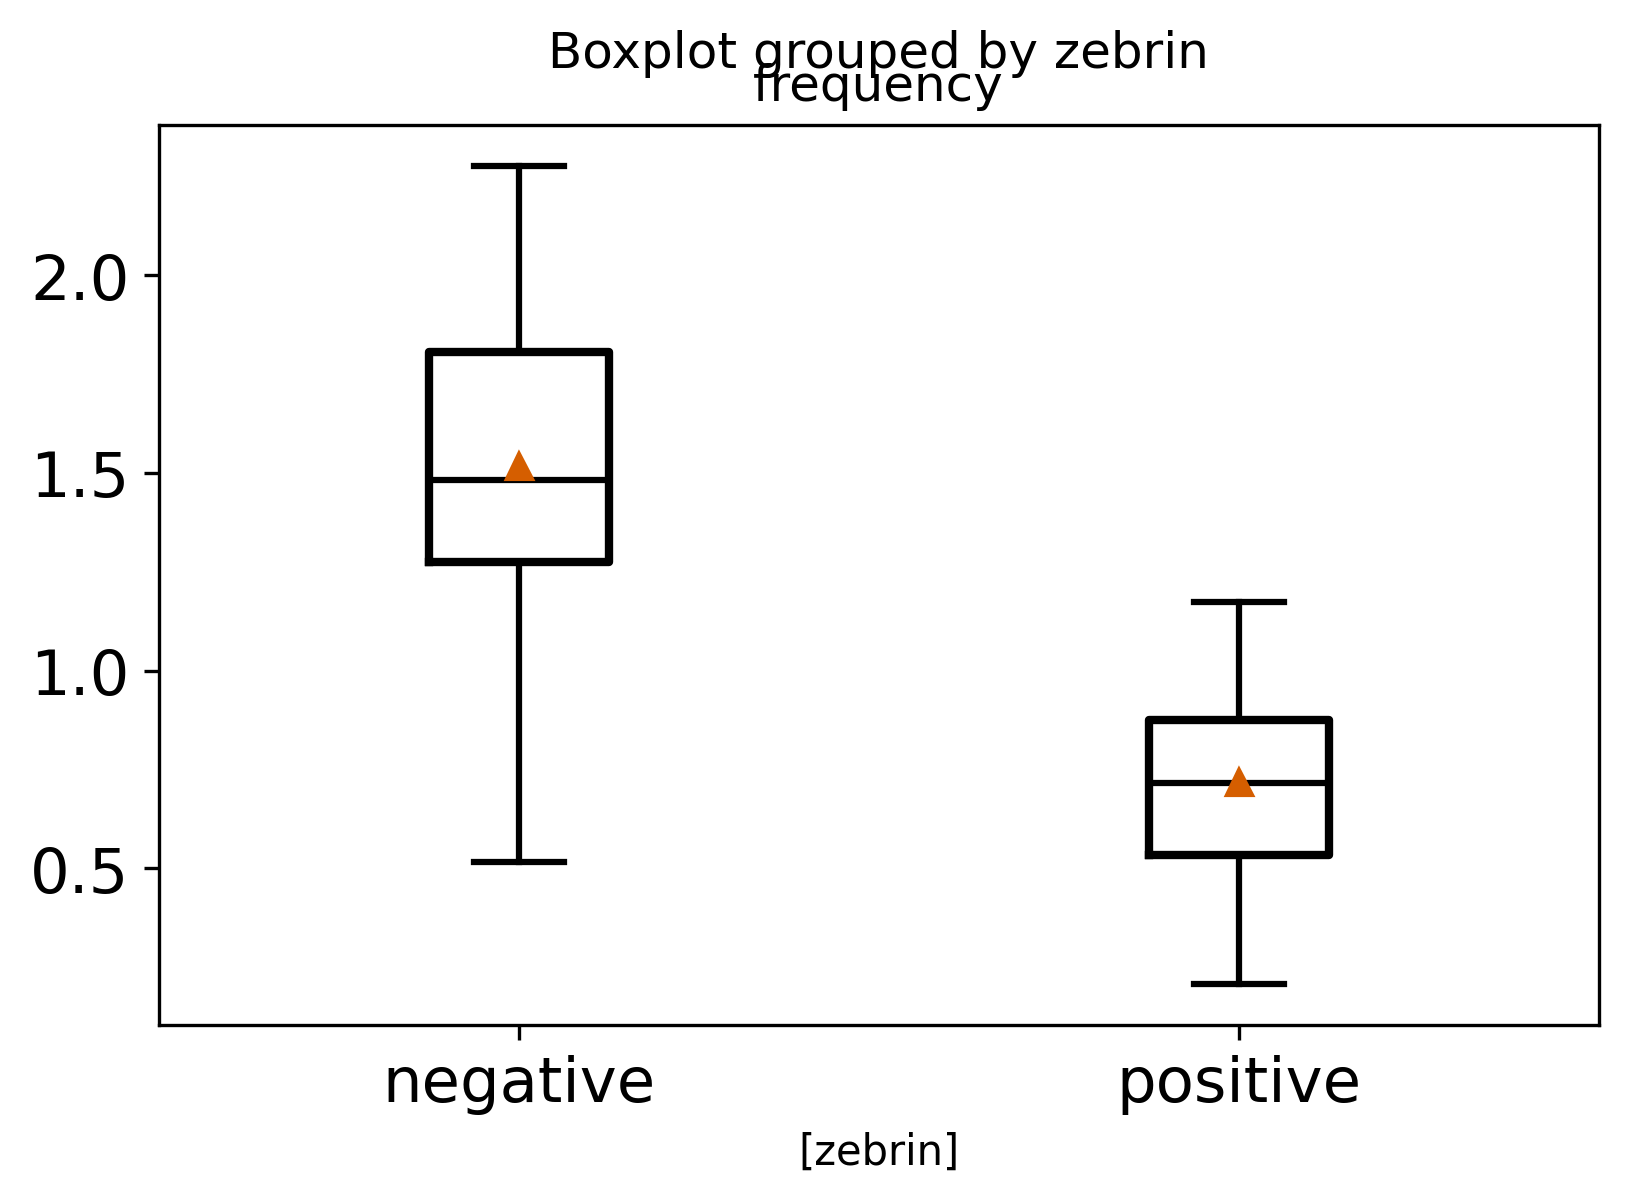

In [16]:
var = 'frequency'
for cell_name in ['IO']:
    df_data = df_ff[(df_ff["cell"]==cell_name) & (df_ff["plasticity"]==names[f'{plasticity}'])]
    Q1, Q3 = percentile(df_data['frequency'],[5,95])
    IQR = Q3 - Q1    #IQR is interquartile range. 
    lower_boundary = Q1 - 1.5 * IQR
    upper_boundary = Q3 + 1.5 * IQR
    df_data2 = df_data[(df_data['frequency'] < upper_boundary) & (df_data['frequency'] > lower_boundary)]
    fig = plt.figure(dpi=300)
    title(f'{cell_name}')

    flierproperties = dict(markerfacecolor = 'white', markeredgecolor = 'white')
    bp = df_data2.boxplot(column=var, by=['zebrin'], showmeans=True, grid=False, figsize=(4,3), widths=0.25,fontsize=15,
                         color=dict(boxes='k', whiskers='k', medians='k', caps='k'),
                         boxprops=dict(linestyle='-', linewidth=2),
                         flierprops=dict(linestyle='-', linewidth=1.5),
                         medianprops=dict(linestyle='-', linewidth=1.5, color = 'k'),
                         whiskerprops=dict(linestyle='-', linewidth=1.5),
                         capprops=dict(linestyle='-', linewidth=1.5),ax = plt.gca())  


In [ ]:
%%time
t_start = 1 * second
t_stop = 29 * second
bin_size = 1 * second
coupling = '_Coupled'

f0 = 'eye_blink_open'

names = {'no_Plasticity': 'NP', 'Plasticity': 'P1', 'after_Plasticity': 'AP1'}
colors = dict(positive='#1c4981',negative='#8a1218')        
cell_pop_sizes = dict(all_pc = range(200),close_pc = range(100),open_pc = range(100,200),IO=range(40))
        
data = []
cell_name = 'PC'
for coupling in (['_Coupled']):
    for cell_type in ['close_pc','open_pc']:
        for zebrin in zebrin_range:
            for order,plasticity in enumerate(['no_Plasticity']):
                spikes_output = output_load_run(f'{cell_name}_Spikes',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
                for cell_num in cell_pop_sizes[cell_type]:
                    spikes = spikes_output[f'{cell_num}']
                    bin_edges = np.arange(t_start, t_stop+bin_size, bin_size)
                    spike_counts, _ = np.histogram(spikes, bins=bin_edges)
                    mean_count = spike_counts / bin_size
                    row = dict(frequency = mean(mean_count/Hz))
                    row['cell'] = cell_name
                    row['cell_type'] = cell_type
                    row['plasticity'] = names[f'{plasticity}']
                    row['zebrin'] = zebrin
                    row['coupling'] = coupling
                    row['order'] = f'{order}'+names[f'{plasticity}']
                    data.append(row)
df_ff = pd.DataFrame(data)

plasticity = 'no_Plasticity'

var = 'frequency'
x = {}
y = {}
for zebrin in zebrin_range:
    x[zebrin] = {}
    y[zebrin] = {}
    for cell_name in ['PC']:
        df_data = df_ff[(df_ff["zebrin"]==zebrin) & (df_ff["cell"]==cell_name) & (df_ff["plasticity"]==names[f'{plasticity}'])]
        Q1, Q3 = percentile(df_data['frequency'],[5,95])
        IQR = Q3 - Q1    #IQR is interquartile range. 
        lower_boundary = Q1 - 1.5 * IQR
        upper_boundary = Q3 + 1.5 * IQR
        df_data2 = df_data[(df_data['frequency'] < upper_boundary) & (df_data['frequency'] > lower_boundary)]
        fig = plt.figure(dpi=300)
        title(f'{cell_name}')

        flierproperties = dict(markerfacecolor = 'white', markeredgecolor = 'white')
        bp = df_data2.boxplot(column=var, by=['cell_type'], grid=False, figsize=(4,3), widths=0.25,fontsize=15,
                             color=dict(boxes='k', whiskers='k', medians='k', caps='k'),
                             boxprops=dict(linestyle='-', linewidth=2),
                             flierprops=dict(linestyle='-', linewidth=1.5),
                             medianprops=dict(linestyle='-', linewidth=1.5, color = 'k'),
                             whiskerprops=dict(linestyle='-', linewidth=1.5),
                             capprops=dict(linestyle='-', linewidth=1.5),ax = plt.gca(),positions=[2,1])  
        colors = dict(positive='#1c4981',negative='#8a1218')   
        x[zebrin][cell_name] = {}
        y[zebrin][cell_name] = {}
        for i,coupling in enumerate(['close_pc','open_pc']):
            y[zebrin][cell_name][f'{coupling}'] = df_data2.frequency[(df_data2.cell_type==coupling) & (df_data2.plasticity==names[f'{plasticity}'])].dropna()
#             x[zebrin][cell_name][f'{coupling}'] = [1+i]*len(y[zebrin][cell_name][f'{coupling}'])
            x[zebrin][cell_name][f'{coupling}'] = rand_params(1+i, 1, len(y[zebrin][cell_name][f'{coupling}']), 0.001)#np.random.normal(1+j+(len(plasticity_range[0:1]))*i, 0.12, size=len(y))    # Add some random "jitter" to the x-axis
            scatter(x[zebrin][cell_name][f'{coupling}'], y[zebrin][cell_name][f'{coupling}'], color=f'{colors[zebrin]}', alpha=0.2)
#         toPlot = zip(x[zebrin][cell_name]['close_pc'], y[zebrin][cell_name]['close_pc'], x[zebrin][cell_name]['open_pc'], y[zebrin][cell_name]['open_pc'])
#         for tuple in toPlot:
#             plot([tuple[0], tuple[2]], [tuple[1], tuple[3]], color=f'{colors[zebrin]}',alpha=0.2)
        xticks([1,2],['close_pc','open_pc'])
        sns.despine(trim=True)
        plt.show()
    
    
data = []
cell_name = 'IO'
for coupling in (['_Coupled']):
    for zebrin in ['positive','positive2']:
        for order,plasticity in enumerate(['no_Plasticity']):
            zebrin_name = 'positive'
            if zebrin=='positive2': 
                zebrin='positive'
                zebrin_name = 'positive2'
            spikes_output = output_load_run(f'{cell_name}_Spikes',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
            for cell_num in cell_pop_sizes[cell_name]:
                spikes = spikes_output[f'{cell_num}']
                bin_edges = np.arange(t_start, t_stop+bin_size, bin_size)
                spike_counts, _ = np.histogram(spikes, bins=bin_edges)
                mean_count = spike_counts / bin_size
                row = dict(frequency = mean(mean_count/Hz))
                row['cell'] = cell_name
                row['plasticity'] = names[f'{plasticity}']
                row['zebrin'] = zebrin_name
                row['coupling'] = coupling
                row['order'] = f'{order}'+names[f'{plasticity}']
                data.append(row)
df_ff = pd.DataFrame(data)

var = 'frequency'
x = {}
y = {}

x[zebrin] = {}
y[zebrin] = {}
for cell_name in ['IO']:
    df_data = df_ff[(df_ff["cell"]==cell_name) & (df_ff["plasticity"]==names[f'{plasticity}'])]
    Q1, Q3 = percentile(df_data['frequency'],[5,95])
    IQR = Q3 - Q1    #IQR is interquartile range. 
    lower_boundary = Q1 - 1.5 * IQR
    upper_boundary = Q3 + 1.5 * IQR
    df_data2 = df_data[(df_data['frequency'] < upper_boundary) & (df_data['frequency'] > lower_boundary)]
    fig = plt.figure(dpi=300)
    title(f'{cell_name}')

    flierproperties = dict(markerfacecolor = 'white', markeredgecolor = 'white')
    bp = df_data2.boxplot(column=var, by=['zebrin'], grid=False, figsize=(4,3), widths=0.25,fontsize=15,
                         color=dict(boxes='k', whiskers='k', medians='k', caps='k'),
                         boxprops=dict(linestyle='-', linewidth=2),
                         flierprops=dict(linestyle='-', linewidth=1.5),
                         medianprops=dict(linestyle='-', linewidth=1.5, color = 'k'),
                         whiskerprops=dict(linestyle='-', linewidth=1.5),
                         capprops=dict(linestyle='-', linewidth=1.5),ax = plt.gca(),positions=[2,1])  
#         colors = dict(positive='#1c4981',negative='#8a1218')   
#         x[zebrin][cell_name] = {}
#         y[zebrin][cell_name] = {}
#         for i,coupling in enumerate(['close_pc','open_pc']):
#             y[zebrin][cell_name][f'{coupling}'] = df_data2.frequency[(df_data2.cell_type==coupling) & (df_data2.plasticity==names[f'{plasticity}'])].dropna()
# #             x[zebrin][cell_name][f'{coupling}'] = [1+i]*len(y[zebrin][cell_name][f'{coupling}'])
#             x[zebrin][cell_name][f'{coupling}'] = rand_params(1+i, 1, len(y[zebrin][cell_name][f'{coupling}']), 0.001)#np.random.normal(1+j+(len(plasticity_range[0:1]))*i, 0.12, size=len(y))    # Add some random "jitter" to the x-axis
#             scatter(x[zebrin][cell_name][f'{coupling}'], y[zebrin][cell_name][f'{coupling}'], color=f'{colors[zebrin]}', alpha=0.2)
# #         toPlot = zip(x[zebrin][cell_name]['close_pc'], y[zebrin][cell_name]['close_pc'], x[zebrin][cell_name]['open_pc'], y[zebrin][cell_name]['open_pc'])
# #         for tuple in toPlot:
# #             plot([tuple[0], tuple[2]], [tuple[1], tuple[3]], color=f'{colors[zebrin]}',alpha=0.2)
#         xticks([1,2],['close_pc','open_pc'])
#         sns.despine(trim=True)
#         plt.show()

fig = plt.figure(dpi=300)
IO_v = output_load_run(f'IO',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)['Vs']
for ii in range(len(IO_v)):
    plot(IO_v[ii]/mV)